In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from types import SimpleNamespace
import mendeleev

calc_dir = Path.cwd().joinpath('../calcs')

In [2]:
def collect_data():
    table = []
    for output in calc_dir.glob('*.json'):
        atom, iden = output.stem.split('_')
        
        if iden == 'nrel':
            has_nuc, has_coul, has_xc = 0, 0, 0
        else:
            has_nuc, has_coul, has_xc = [int(c) for c in iden]
            
        try:
            e = json.load(output.open(), object_hook=lambda x: SimpleNamespace(**x)).output.properties.scf_energy.E_tot
        except (AttributeError, KeyError):
            print('Job not done: ', output.name)
            e = None
            
        table.append((atom, has_nuc, has_coul, has_xc, e))
    
    columns = ['Element', 'nuc', 'coul', 'xc', 'Energy']
    return pd.DataFrame(table, columns=columns).sort_values(by=columns[:-1]).reset_index(drop=True)


def get_label(identifier):
    labels = ['nuc', 'coul', 'xc']
    return '\n'.join([label for label, c in zip(labels, identifier) if bool(int(c))])


def digit_sum(d):
    s = 0
    for i in str(d):
        s += int(i)
    return s

## Relative contributions of the ZORA terms

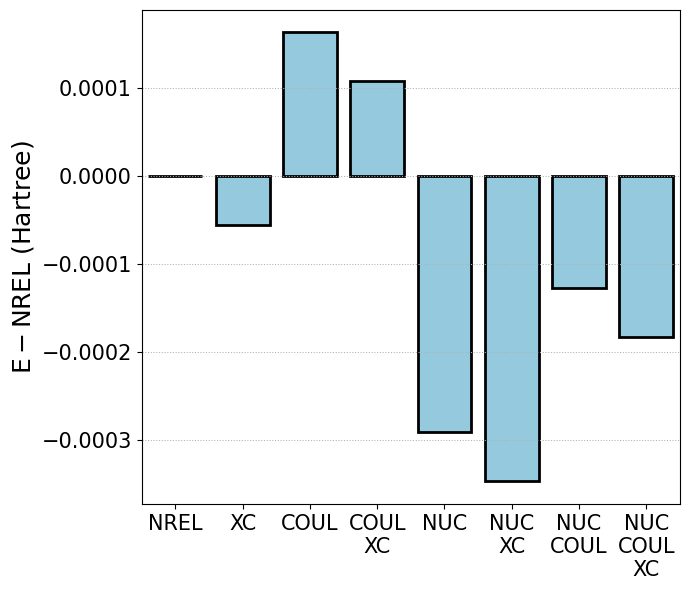

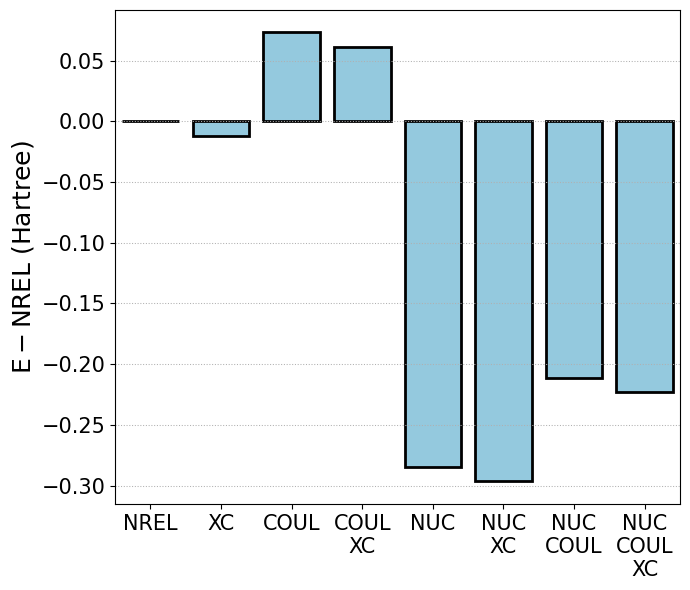

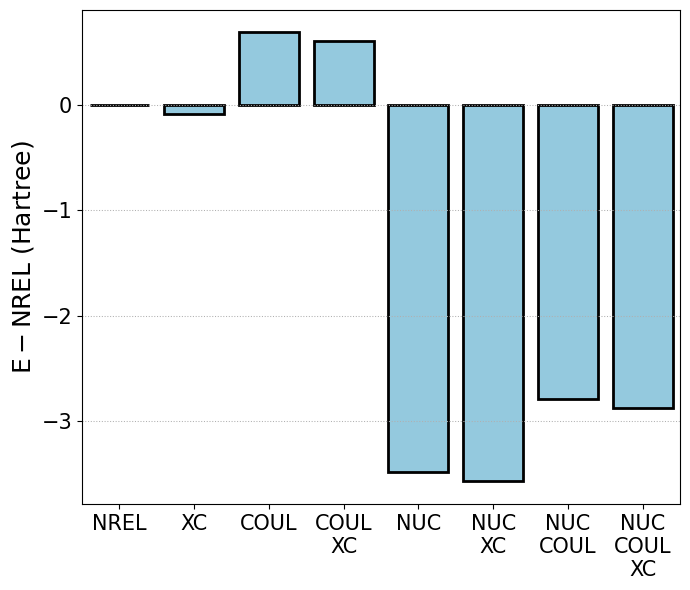

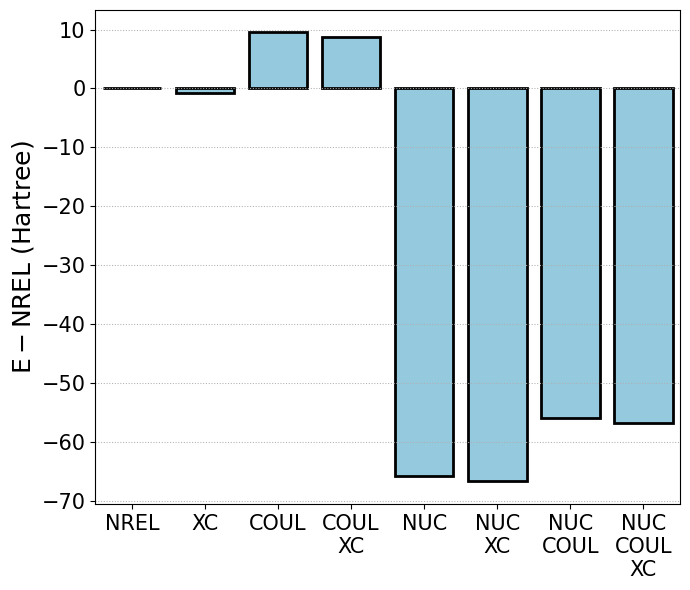

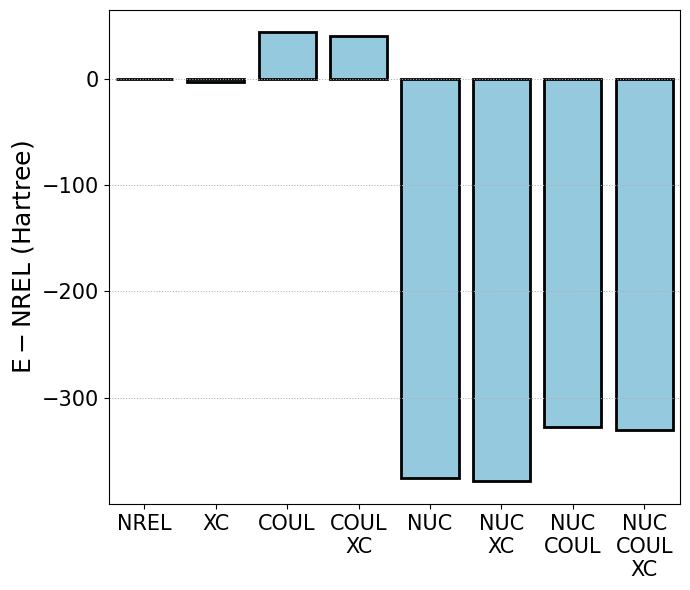

In [3]:
df = collect_data()
df['Label'] = df.nuc.astype(str) + df.coul.astype(str) + df.xc.astype(str)
df['nel'] = df.Element.apply(lambda x: mendeleev.element(x).atomic_number)
df = df.sort_values(by=['nel', 'Label']).reset_index(drop=True)

FS = 18

for element, group in df.groupby(['Element'], sort=False):
    ref = group.loc[group.Label == '000'].Energy.values[0]
    group['DeltaE'] = group.Energy - ref
    group['RelDeltaE'] = group.DeltaE / ref
    
    # print(group[['Element', 'nuc', 'coul', 'xc', 'Energy', 'DeltaE']].to_string(index=False, header=True))
        
    fig, ax = plt.subplots(dpi=100, figsize=(7, 6))
    #ax.set_title(f'Element: {element}', fontsize=FS)
    ax.grid(ls=':', lw=0.75)
    
    sns.barplot(x=group.Label, y=group.DeltaE, ax=ax, color='skyblue', ec='black', lw=2)
    
    ax.set_ylabel(r'$\mathrm{E} - \mathrm{NREL}$ (Hartree)', fontsize=FS)
    ax.set_xlabel(None)
    
    labels = [get_label(t.get_text()).upper() for t in ax.get_xticklabels()]
    labels[0] = 'NREL'
    ax.set_xticklabels(labels, rotation=0)
    ax.tick_params(labelsize=FS-3)
    
    fig.tight_layout()
    fig.savefig(f'figs/relative_contributions_{element}.png', facecolor='white')
    #fig.clear()

### Relative accuracy compared to full ZORA
Compare the total energies for different combinations of terms to the full ZORA.

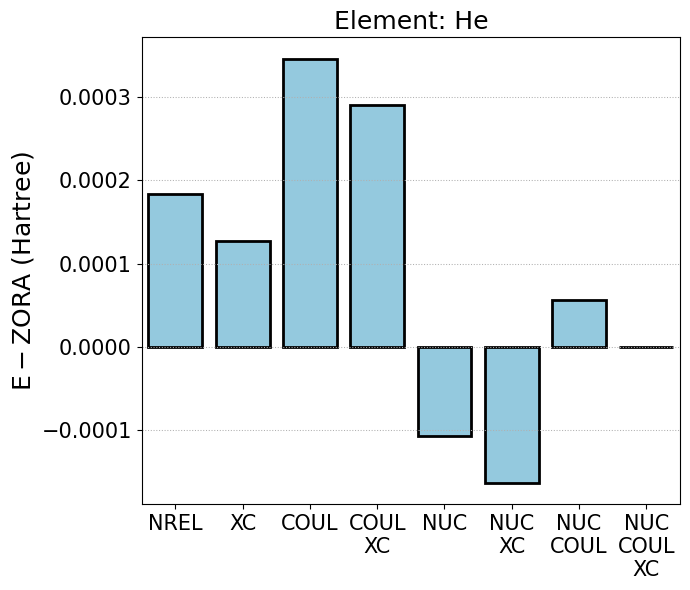

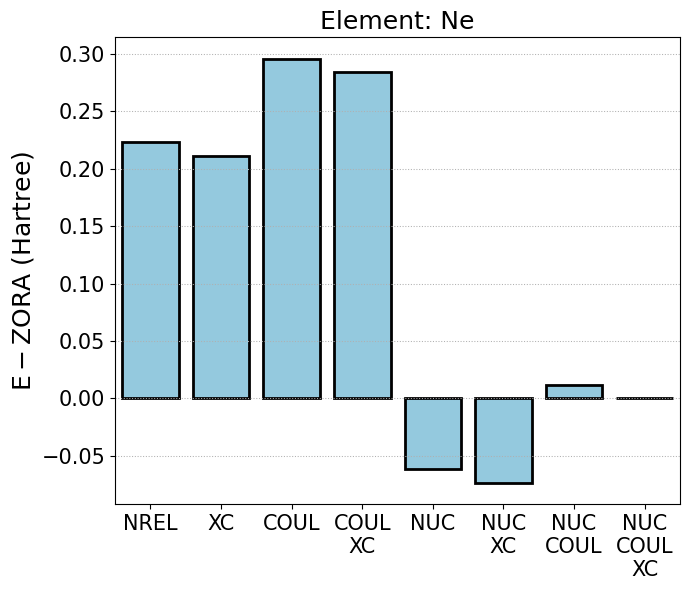

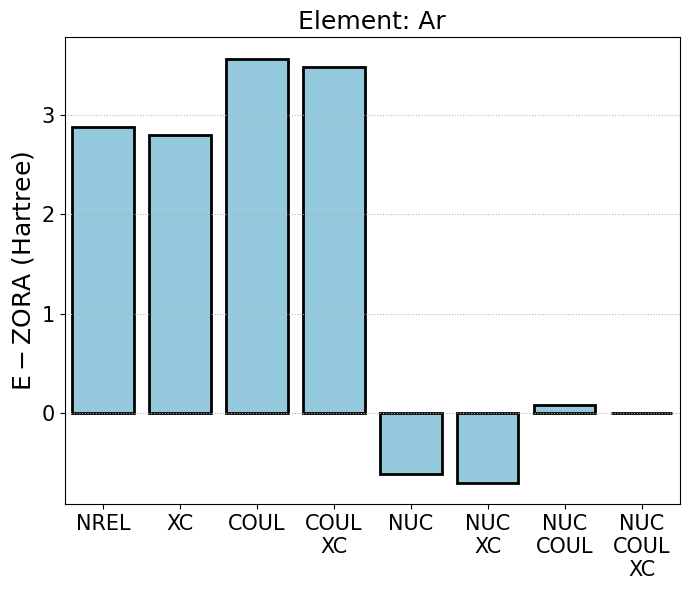

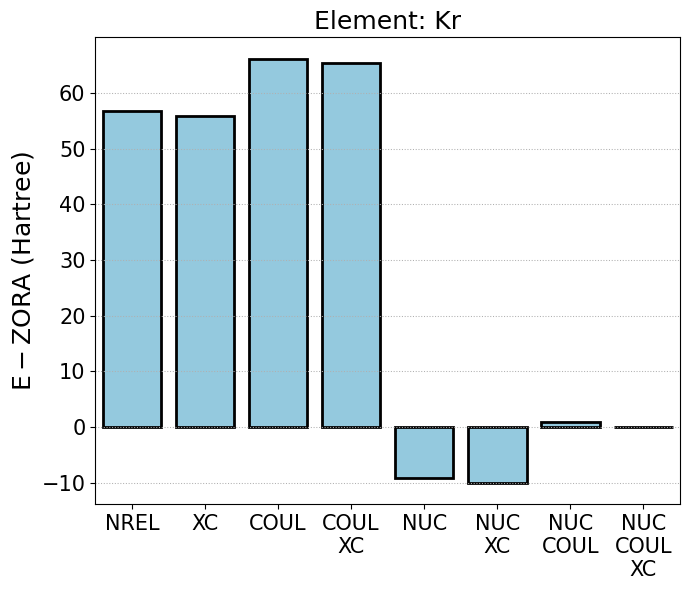

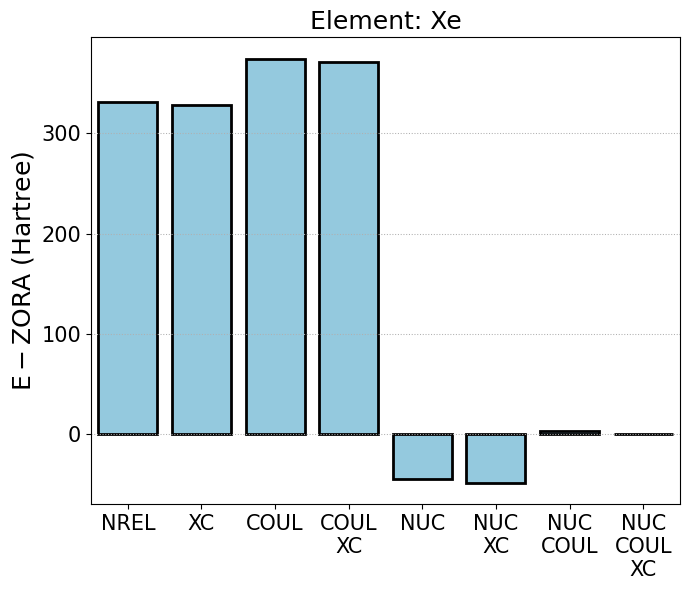

In [4]:
df = collect_data()
df['Label'] = df.nuc.astype(str) + df.coul.astype(str) + df.xc.astype(str)
df['nel'] = df.Element.apply(lambda x: mendeleev.element(x).atomic_number)
df = df.sort_values(by=['nel', 'Label']).reset_index(drop=True)

FS = 18

for element, group in df.groupby(['Element'], sort=False):
    ref = group.loc[group.Label == '111'].Energy.values[0]
    group['DeltaE'] = group.Energy - ref
    group['RelDeltaE'] = group.DeltaE / ref
    
    # print(group[['Element', 'nuc', 'coul', 'xc', 'Energy', 'DeltaE']].to_string(index=False, header=True))
        
    fig, ax = plt.subplots(dpi=100, figsize=(7, 6))
    ax.set_title(f'Element: {element}', fontsize=FS)
    ax.grid(ls=':', lw=0.75)
    
    sns.barplot(x=group.Label, y=group.DeltaE, ax=ax, color='skyblue', ec='black', lw=2)
    
    ax.set_ylabel(r'$\mathrm{E} - \mathrm{ZORA}$ (Hartree)', fontsize=FS)
    ax.set_xlabel(None)
    
    labels = [get_label(t.get_text()).upper() for t in ax.get_xticklabels()]
    labels[0] = 'NREL'
    ax.set_xticklabels(labels)
    ax.tick_params(labelsize=FS-3)
    
    fig.tight_layout()
    fig.savefig(f'figs/ZORA_term_accuracy_{element}_acc.png', facecolor='white')
    #fig.clear()

### Additivity of the ZORA terms
Compare 
- ZORA(nuc + coul + xc)
- ZORA(nuc) + ZORA(coul) + ZORA(xc)

In [5]:
df = collect_data()
df['Label'] = df.nuc.astype(str) + df.coul.astype(str) + df.xc.astype(str)
df['nel'] = df.Element.apply(lambda x: mendeleev.element(x).atomic_number)
df = df.sort_values(by=['nel', 'Label']).reset_index(drop=True)

table = []
for element, g in df.groupby('Element', sort=False):
    nrel = g.loc[g.Label == '000'].Energy.iloc[0]
    zora = g.loc[g.Label == '111'].Energy.iloc[0]
    d_nuc = g.loc[g.Label == '100'].Energy.iloc[0] - nrel
    d_coul = g.loc[g.Label == '010'].Energy.iloc[0] - nrel
    d_xc = g.loc[g.Label == '001'].Energy.iloc[0] - nrel
    added = nrel + d_nuc + d_coul + d_xc
    
    error = added - zora
    
    table.append((element, zora, nrel, added))
    
df = pd.DataFrame(table, columns=['Element', 'ZORA', 'Added', 'NREL'])
df.index = df.Element.tolist()
df = df.transpose().reset_index()
df = df.rename(columns={'index': 'Method'})

In [7]:
print(df.transpose().to_latex())

\begin{tabular}{lllll}
\toprule
{} &        0 &            1 &            2 &            3 \\
\midrule
Method &  Element &         ZORA &        Added &         NREL \\
He     &       He &    -2.893119 &    -2.892935 &    -2.893119 \\
Ne     &       Ne &  -129.089374 &  -128.866433 &  -129.089641 \\
Ar     &       Ar &  -530.224735 &  -527.346141 &  -530.232782 \\
Kr     &       Kr & -2810.075235 & -2753.416137 &  -2810.47807 \\
Xe     &       Xe & -7564.899013 & -7234.233258 & -7568.956891 \\
\bottomrule
\end{tabular}



In [8]:
df

,Method,He,Ne,Ar,Kr,Xe
0,Element,He,Ne,Ar,Kr,Xe
1,ZORA,-2.893119,-129.089374,-530.224735,-2810.075235,-7564.899013
2,Added,-2.892935,-128.866433,-527.346141,-2753.416137,-7234.233258
3,NREL,-2.893119,-129.089641,-530.232782,-2810.47807,-7568.956891
